In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [5]:
#taking all rows of data from our final_features_train file as running for all data is throwing memory error
if os.path.isfile('final_features_train.csv'):
    final_features_train = pd.read_csv('final_features_train.csv') 
else:
    print('please train Q_mean_W2V python file for 100k datapoints to generate features')
    
    

In [6]:
final_features_train.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-72.718146,-37.148066,-31.490608,94.141156,-44.950640,-34.465247,-76.634255,100.025111,51.065072,-17.637276
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,6.585885,-59.548013,-16.186697,0.061812,26.350538,164.450202,-58.135197,189.703480,122.129779,56.350818
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,-26.912855,-19.578777,75.006603,23.602108,-92.495243,-178.372608,-91.454193,20.879006,22.670340,49.185106
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-17.692158,29.719559,49.373642,27.600317,25.019165,-33.121244,-3.266130,-14.854872,4.196988,7.882364
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,36.232958,47.269621,-49.664346,45.108631,39.767184,-33.761699,-98.386384,22.079260,68.230127,21.040859


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [7]:
#Creating train db file from csv
if not os.path.isfile('train_70k.db'):
    disk_engine = create_engine('sqlite:///train_70k.db')
    start = dt.datetime.now()
    chunksize = 14000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_train.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data_train', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1        
else:
    print('File already present in the drive')

14000 rows
28000 rows
42000 rows
56000 rows
70000 rows
84000 rows


In [8]:
#Creating db file from test csv
if not os.path.isfile('test_30k.db'):
    disk_engine = create_engine('sqlite:///test_30k.db')
    start = dt.datetime.now()
    chunksize = 10000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_test.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data_test', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1        
else:
    print('File already present in the drive')

10000 rows
20000 rows
30000 rows
40000 rows


In [9]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [23]:
read_db = 'train_70k.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data_train


In [24]:
#try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data_train = pd.read_sql_query("SELECT * From data_train;", conn_r)
        conn_r.commit()
        conn_r.close()

In [25]:
# remove the first row 
data_train.drop(data_train.index[0], inplace=True)
y_true = data_train['is_duplicate']
data_train.drop(['Unnamed: 0', 'id','is_duplicate','index'], axis=1, inplace=True)

In [26]:
data_train.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,0.0,1.0,2.0,13.0,...,-72.71814632415771,-37.148065984249115,-31.49060845375061,94.14115607738495,-44.95064043998718,-34.465246595442295,-76.63425534963608,100.02511137723923,51.06507237255573,-17.63727593421936
2,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,0.0,1.0,5.0,12.5,...,6.585885405540466,-59.548013269901276,-16.186697378754616,0.06181211769580841,26.350537687540054,164.4502021074295,-58.13519740104675,189.70348000526428,122.12977933883667,56.350818037986755
3,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.24999687503906198,0.3999960000399996,0.28571224491253633,0.0,1.0,4.0,12.0,...,-26.91285538673401,-19.578776761889458,75.00660336017609,23.60210806131363,-92.49524259567261,-178.37260788679123,-91.4541928768158,20.879005789756775,22.670340299606323,49.18510577455163
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,...,-17.692158341407776,29.719559133052826,49.37364239990711,27.600317001342773,25.0191650390625,-33.12124443054199,-3.2661298513412476,-14.85487174987793,4.196987628936768,7.882364273071289
5,0.3999920001599968,0.19999800001999984,0.9999500024998748,0.6666444451851604,0.5714204082798817,0.3076899408466089,0.0,1.0,6.0,10.0,...,36.23295804485679,47.26962113380432,-49.66434621810913,45.108630895614624,39.767184406518936,-33.761698722839355,-98.38638353347778,22.07925969362259,68.23012709617615,21.04085874557495


In [27]:
#storing and reading the test data
read_db = 'test_30k.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

#try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data_test = pd.read_sql_query("SELECT * From data_test;", conn_r)
        conn_r.commit()
        conn_r.close()

# remove the first row 
data_test.drop(data_test.index[0], inplace=True)
y_true_test = data_test['is_duplicate']
data_test.drop(['Unnamed: 0', 'id','is_duplicate','index'], axis=1, inplace=True)

Tables in the databse:
data_test


<h2> 4.2 Converting strings to numerics </h2>

In [28]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data_train.columns)
for i in cols:
    data_train[i] = data_train[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [29]:
# after we read from sql table each entry was read it as a string
# we convert all the test features into numaric before we apply any model
cols = list(data_test.columns)
for i in cols:
    data_test[i] = data_test[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [30]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))
y_true_test = list(map(int, y_true_test.values))

# Storing train,test data to be fed to models

In [31]:
X_train = data_train
X_test = data_test
y_train = y_true
y_test = y_true_test

In [ ]:
#np.isnan(X_train).any().value_counts()

In [ ]:
#X_train = X_train.fillna('')

In [32]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [33]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275428571428572 Class 1:  0.3724571428571429
---------- Distribution of output variable in test data ----------
Class 0:  0.6272666666666666 Class 1:  0.37273333333333336


In [34]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8834092307256727


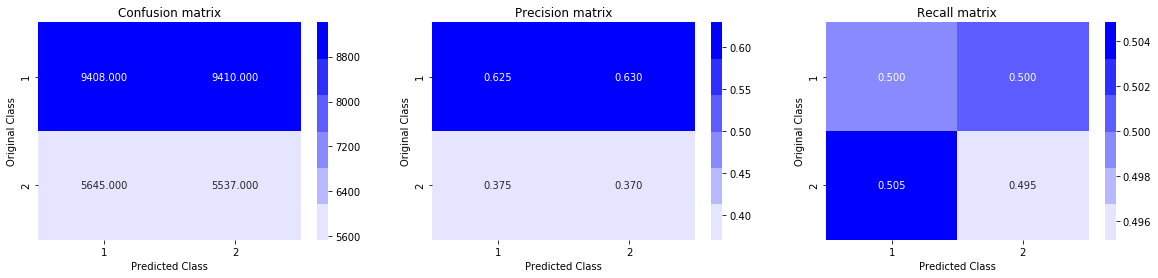

In [35]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
log_loss_random_model = log_loss(y_test, predicted_y, eps=1e-15)
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.49632237103048543
For values of alpha =  0.0001 The log loss is: 0.4978908415268128
For values of alpha =  0.001 The log loss is: 0.5004041430704348
For values of alpha =  0.01 The log loss is: 0.5035940871450374
For values of alpha =  0.1 The log loss is: 0.5065390457862332
For values of alpha =  1 The log loss is: 0.5278004937428971
For values of alpha =  10 The log loss is: 0.5612711477440843


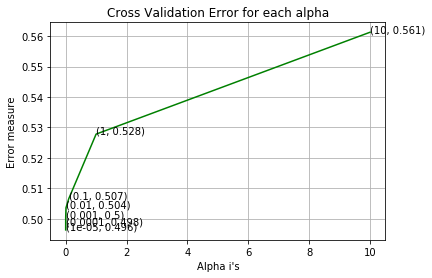

For values of best alpha =  1e-05 The train log loss is: 0.48969361001930417
For values of best alpha =  1e-05 The test log loss is: 0.49632237103048543
Total number of data points : 30000


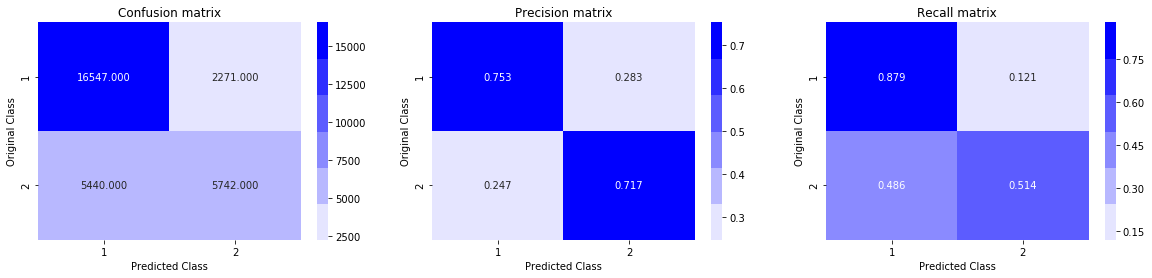

In [36]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
log_loss_train_lr = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
log_loss_test_lr = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [37]:
#X_train[X_train.isnull()]

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6603945396142471
For values of alpha =  0.0001 The log loss is: 0.5268544949399735
For values of alpha =  0.001 The log loss is: 0.5267478219658294
For values of alpha =  0.01 The log loss is: 0.5549789376625109
For values of alpha =  0.1 The log loss is: 0.614665946680227
For values of alpha =  1 The log loss is: 0.6367164960214842
For values of alpha =  10 The log loss is: 0.6460249926060778


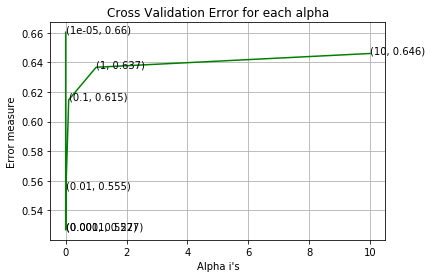

For values of best alpha =  0.001 The train log loss is: 0.5230666572839103
For values of best alpha =  0.001 The test log loss is: 0.5267478219658294
Total number of data points : 30000


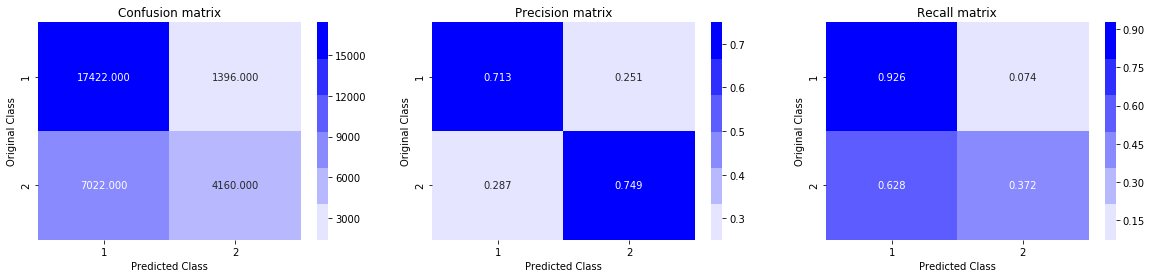

In [38]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)

log_loss_train_svm = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)

log_loss_test_svm = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [39]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)

predict_y = bst.predict(d_train)
log_loss_xgboost_train_default = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = bst.predict(d_test)
log_loss_xgboost_test_default = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685622	valid-logloss:0.685735
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.623435	valid-logloss:0.624435
[20]	train-logloss:0.578183	valid-logloss:0.579912
[30]	train-logloss:0.544074	valid-logloss:0.546431
[40]	train-logloss:0.517738	valid-logloss:0.520505
[50]	train-logloss:0.497196	valid-logloss:0.500278
[60]	train-logloss:0.480887	valid-logloss:0.48424
[70]	train-logloss:0.467738	valid-logloss:0.471386
[80]	train-logloss:0.457457	valid-logloss:0.461314
[90]	train-logloss:0.448756	valid-logloss:0.452737
[100]	train-logloss:0.441374	valid-logloss:0.445593
[110]	train-logloss:0.435066	valid-logloss:0.439546
[120]	train-logloss:0.429802	valid-logloss:0.434549
[130]	train-logloss:0.425207	valid-logloss:0.430202
[140]	train-logloss:0.421548	valid-logloss:0.426853
[150]	train-logloss:0.418117	valid-logloss:0.423755
[160]	train-logloss:0.415329	

Total number of data points : 30000


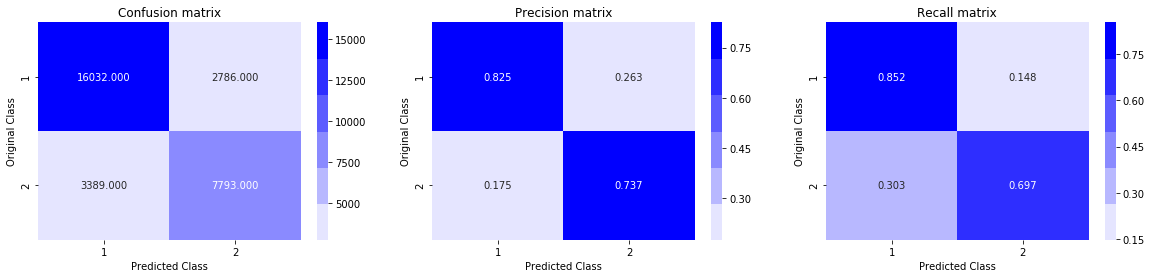

In [40]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.


Assignment 1 has been covered in another notebook TFIDF_ which has been submitted seperately.

2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


In [41]:
import numpy as np

In [42]:
hyperparameters = {'max_depth':[2,4,6,9,11],'n_estimators':[1, 5, 10, 50, 100],'learning_rate':list(np.arange(0.1,0.6,0.1))}


In [43]:
#hyperparameters['objective'] = 'binary:logistic'
#hyperparameters['eval_metric'] = 'logloss'

In [44]:
from sklearn.model_selection import RandomizedSearchCV
XGB_t2v = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss'),param_distributions=hyperparameters,scoring='neg_log_loss',cv=3,random_state=30)
XGB_t2v.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_a...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                     

In [45]:
optimal_depth_XGB_t2v = XGB_t2v.best_params_['max_depth']
optimal_estimators_XGB_t2v = XGB_t2v.best_params_['n_estimators']
optimal_rate_XGB_t2v = XGB_t2v.best_params_['learning_rate']

print('Optimal Depth : ',optimal_depth_XGB_t2v)
print('Optimal_estimators : ',optimal_estimators_XGB_t2v)
print('Optimal Learning Rate : ',optimal_rate_XGB_t2v)

Optimal Depth :  9
Optimal_estimators :  10
Optimal Learning Rate :  0.30000000000000004


In [46]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = optimal_depth_XGB_t2v

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)

predict_y = bst.predict(d_train)
log_loss_xgboost_train_tuned = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = bst.predict(d_test)
log_loss_xgboost_test_tuned = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.683627	valid-logloss:0.684369
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.604928	valid-logloss:0.612039
[20]	train-logloss:0.547412	valid-logloss:0.560283
[30]	train-logloss:0.503709	valid-logloss:0.521963
[40]	train-logloss:0.469603	valid-logloss:0.492679
[50]	train-logloss:0.442505	valid-logloss:0.469897
[60]	train-logloss:0.420659	valid-logloss:0.452116
[70]	train-logloss:0.402677	valid-logloss:0.438055
[80]	train-logloss:0.387541	valid-logloss:0.426457
[90]	train-logloss:0.37478	valid-logloss:0.417157
[100]	train-logloss:0.36432	valid-logloss:0.409684
[110]	train-logloss:0.355265	valid-logloss:0.403478
[120]	train-logloss:0.347433	valid-logloss:0.398335
[130]	train-logloss:0.340698	valid-logloss:0.394294
[140]	train-logloss:0.334647	valid-logloss:0.390958
[150]	train-logloss:0.329093	valid-logloss:0.388231
[160]	train-logloss:0.324316	v

Total number of data points : 30000


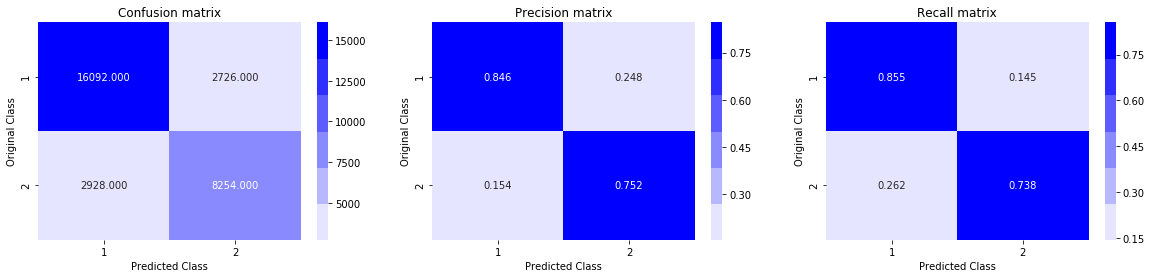

In [47]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [48]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Train log loss','Test log loss']
x.add_row(['Logistic Regression',log_loss_train_lr,log_loss_test_lr])
x.add_row(['SVM',log_loss_train_svm,log_loss_test_svm])
x.add_row(['XGBOOST',log_loss_xgboost_train_default,log_loss_xgboost_test_default])
x.add_row(['XGBOOST(after tuning)',log_loss_xgboost_train_tuned,log_loss_xgboost_test_tuned])

print(x)

+-----------------------+---------------------+---------------------+
|         Model         |    Train log loss   |    Test log loss    |
+-----------------------+---------------------+---------------------+
|  Logistic Regression  | 0.48969361001930417 | 0.49632237103048543 |
|          SVM          |  0.5230666572839103 |  0.5267478219658294 |
|        XGBOOST        |  0.3809442799815808 |  0.3940218739081077 |
| XGBOOST(after tuning) |  0.2497408913811835 |  0.3665882118646754 |
+-----------------------+---------------------+---------------------+


In [49]:
#training XGBOOSt again but with max_depth as the only hyperparameter

Optimal Depth :  9
[0]	train-logloss:0.683627	valid-logloss:0.684369
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.604928	valid-logloss:0.612039
[20]	train-logloss:0.547412	valid-logloss:0.560283
[30]	train-logloss:0.503709	valid-logloss:0.521963
[40]	train-logloss:0.469603	valid-logloss:0.492679
[50]	train-logloss:0.442505	valid-logloss:0.469897
[60]	train-logloss:0.420659	valid-logloss:0.452116
[70]	train-logloss:0.402677	valid-logloss:0.438055
[80]	train-logloss:0.387541	valid-logloss:0.426457
[90]	train-logloss:0.37478	valid-logloss:0.417157
[100]	train-logloss:0.36432	valid-logloss:0.409684
[110]	train-logloss:0.355265	valid-logloss:0.403478
[120]	train-logloss:0.347433	valid-logloss:0.398335
[130]	train-logloss:0.340698	valid-logloss:0.394294
[140]	train-logloss:0.334647	valid-logloss:0.390958
[150]	train-logloss:0.329093	valid-logloss:0.388231
[160]	train

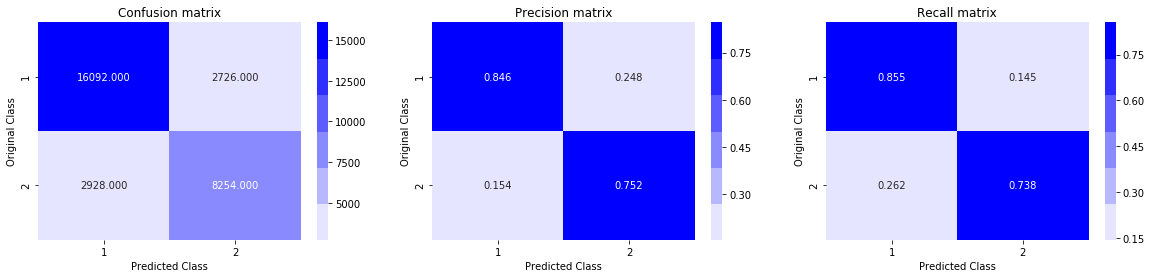

In [50]:
hyperparameters = {'max_depth':[2,4,6,9,11]}


#hyperparameters['objective'] = 'binary:logistic'
#hyperparameters['eval_metric'] = 'logloss'

from sklearn.model_selection import RandomizedSearchCV
XGB_t2v = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss'),param_distributions=hyperparameters,scoring='neg_log_loss',cv=3,random_state=30)
XGB_t2v.fit(X_train,y_train)

optimal_depth_XGB_t2v = XGB_t2v.best_params_['max_depth']

print('Optimal Depth : ',optimal_depth_XGB_t2v)


params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = optimal_depth_XGB_t2v

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)

predict_y = bst.predict(d_train)
log_loss_xgboost_train_tuned2 = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)

predict_y = bst.predict(d_test)
log_loss_xgboost_test_tuned2 = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [51]:
log_loss_xgboost_train_tuned2

0.2497408913811835

Got the same results again

# Conclusion

In [52]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Train log loss','Test log loss']
x.add_row(['Logistic Regression',log_loss_train_lr,log_loss_test_lr])
x.add_row(['SVM',log_loss_train_svm,log_loss_test_svm])
x.add_row(['XGBOOST',log_loss_xgboost_train_default,log_loss_xgboost_test_default])
x.add_row(['XGBOOST(tuned with max_depth,n_estimators & learning_rate)',log_loss_xgboost_train_tuned,log_loss_xgboost_test_tuned])
x.add_row(['XGBOOST(tuned with max_depth)',log_loss_xgboost_train_tuned2,log_loss_xgboost_test_tuned2])

print(x)

+------------------------------------------------------------+---------------------+---------------------+
|                           Model                            |    Train log loss   |    Test log loss    |
+------------------------------------------------------------+---------------------+---------------------+
|                    Logistic Regression                     | 0.48969361001930417 | 0.49632237103048543 |
|                            SVM                             |  0.5230666572839103 |  0.5267478219658294 |
|                          XGBOOST                           |  0.3809442799815808 |  0.3940218739081077 |
| XGBOOST(tuned with max_depth,n_estimators & learning_rate) |  0.2497408913811835 |  0.3665882118646754 |
|               XGBOOST(tuned with max_depth)                |  0.2497408913811835 |  0.3665882118646754 |
+------------------------------------------------------------+---------------------+---------------------+


All the models have been trained with 100k rows of data and 221 fetaures

XGBOOST is working the best for this data if seen from log_loss angle of both train and test unit